## <center> Modelo de Reclamaciones de Seguros </center>
Vinton Auto Insurance está tratando de decidir cuánto dinero debe mantener en activos líquidos para cubrir las reclamaciones de seguros. En el pasado, la empresa guardaba parte de las primas que recibía en cuentas corrientes que devengaban intereses y el resto lo invertía en activos que, aunque no son tan líquidos, suelen generar un mayor rendimiento. La compañía quiere estudiar los flujos de efectivo para determinar cuánto dinero debe mantener en activos líquidos para pagar las reclamaciones. Tras revisar los datos históricos, la empresa determinó que la factura promedio de reparación por siniestro se distribuye normalmente con una media de $1,700 y una desviación estándar de $400. También determinó que la cantidad de reclamaciones de reparación presentadas cada semana es una variable aleatoria que sigue la distribución de probabilidad que se muestra en la siguiente tabla:

$$
\begin{array}{c|ccccccccc}
\text{Reclamaciones} & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
\hline
\text{Probabilidad} & 0.05 & 0.06 & 0.10 & 0.17 & 0.28 & 0.14 & 0.08 & 0.07 & 0.05
\end{array}
$$

Además de las reclamaciones por reparaciones, la empresa también recibe reclamaciones por autos que han quedado en "pérdida total" y no se pueden reparar. Existe una probabilidad del 20 % de recibir este tipo de reclamación en cualquier semana. Estas reclamaciones por autos en  "pérdida total" suelen costar entre 2,000 y 35,000 dólares, siendo 13,000 dólares el coste más habitual.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 0. Análisis Número de reclamos

Verificar si la distribucción es Poisson

In [2]:
# Datos
reclamos = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
f_relativa = np.array([0.05, 0.06, 0.10, 0.17, 0.28, 0.14, 0.08, 0.07, 0.05])

lambda_estimada =np.sum(reclamos * f_relativa)

poisson_teorica = stats.poisson.pmf(reclamos, lambda_estimada)

N_100 = 100
f_observada = f_relativa * N_100
f_esperada = poisson_teorica * N_100

# Agrupación de clases
f_obs_nueva = [f_observada[0] + f_observada[1],
               f_observada[2], f_observada[3],
               f_observada[4], f_observada[5], f_observada[6],
               f_observada[7] + f_observada[8]]

f_esp_nueva = [f_esperada[0] + f_esperada[1],
               f_esperada[2], f_esperada[3],
               f_esperada[4], f_esperada[5], f_esperada[6],
               f_esperada[7] + f_esperada[8]]

# Realizar la prueba chi-cuadrado
prueba = stats.chisquare(f_obs_nueva, f_esp_nueva,ddof=-1,sum_check=False)
print(f'Estadístico de prueba: {prueba.statistic}')
print(f'Valor crítico: {prueba.pvalue}')
print(f'¿Se rechaza H0?: {prueba.pvalue < 0.05}')

Estadístico de prueba: 8.608359107961459
Valor crítico: 0.2820099409547405
¿Se rechaza H0?: False


### 1. Entradas conocidas

In [3]:
lambda_frecuencia  = lambda_estimada
mu_rep, sigma_rep = 1700, 400
min_pt, mod_pt, max_pt = 2000, 13000, 35000
prob = 0.20

n_sim = 1000

### 2. Variables de decisión

In [4]:
activos_liquidos = 20000

### 3. Entradas inciertas

In [5]:
def r_reparacion(u):
    return stats.poisson.rvs(u)

# Pago total reparaciones
def pago_reparaciones(localizacion, escala, frecuencia):
    pagos = stats.norm.rvs(loc=localizacion, scale=escala, size=frecuencia)
    return pagos

# Pago pérdida total
def p_perdida_total(minimo, moda, maximo):
    moda_rel = (moda-minimo)/(maximo-minimo)
    localizacion = minimo
    escala = maximo - minimo
    return stats.triang.rvs(moda_rel,localizacion,escala)

# Verificar si en la semana hubo pérdid total
def h_perdida_total(p_exito):
    return stats.bernoulli.rvs(p_exito,loc=0)

### 4. Calculos intermedios

In [6]:
def simular_perdidas(ensayos):
    pagos_totales = []
    for _ in range(ensayos):
        frec_simulada = r_reparacion(lambda_frecuencia)
        severidad_sim = pago_reparaciones(mu_rep, sigma_rep, frec_simulada)
        severidad_perdida_total_sim = h_perdida_total(prob) * p_perdida_total(min_pt,mod_pt,max_pt)
        pagos_totales.append(np.sum(severidad_sim) + severidad_perdida_total_sim)
    return pagos_totales

### 5. Salida

Pago promedio semanal = 11656.0170
Máximo pago semanal = 43570.5285
Mínimo pago semanal = 0.0000
P(Pago Total > 20000) = 0.14


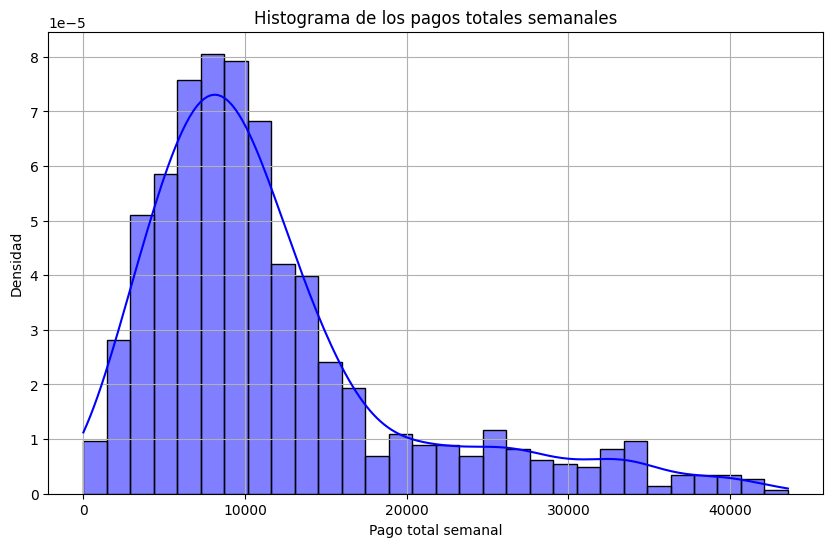

In [8]:
pago_total_semanal = simular_perdidas(n_sim)
condicion= (np.array(pago_total_semanal) > 20000)
prob1=np.sum(condicion)/len(pago_total_semanal)
print(f'Pago promedio semanal = {np.mean(pago_total_semanal):.4f}')
print(f'Máximo pago semanal = {np.max(pago_total_semanal):.4f}')
print(f'Mínimo pago semanal = {np.min(pago_total_semanal):.4f}')
print(f"P(Pago Total > 20000) = {prob1:.2f}")

# Gráfica
plt.figure(figsize=(10, 6))
sns.histplot(pago_total_semanal, kde=True, stat='density', color='blue')
plt.title('Histograma de los pagos totales semanales')
plt.xlabel('Pago total semanal')
plt.ylabel('Densidad')
plt.grid()
plt.show()
